# TensorFlow Regression Tutorial

This is a simple tutorial on how to use TensorFlow for performing linear and non-linear regression using gradient descent and stochastic gradient descent (SGD).  Most of the code and functionality shown in this tutorial was obtained from [this](https://www.youtube.com/playlist?list=PLXO45tsB95cJHXaDKpbwr5fC_CCYylw1f) excellent YouTube series by Morvan.

The code is written to also make use of TensorBoard, which fascilitates visualizing the network as a graph and also to show any parameter, performance statistic or variable of your choosing.  A basic understanding of neural networks is required to follow this tutorial, as well as a working installation of TensorFlow.

### Linear Regression Using Gradient Descent

Firstly, import the necessary modules, initialize the random number generator with a seed and set matplotlib to produce plots inline.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

np.random.seed(1)
%matplotlib inline

The next step is to generate some data for a straight line.  Adding noise to this data will make it look more realistic.

In [2]:
# create x and y arrays for data
# specify the slope (m) and y-intercept (c) for the straight line
m = 2.0
c = 3.0
xDat = np.linspace(-1, 1, 300).reshape((-1,1)).astype(np.float32)
noise = np.random.normal(0, 0.1, xDat.shape).astype(np.float32)
yDat = m*xDat + c + noise

We define `x` and `y` placeholders for feeding `xDat` and `yDat` into the TensorFlow graph.  This will come in handy when doing stochastic gradient descent.  For now we only perform full gradient descent, i.e. we consider all of the training data when calculating gradients during each training step.  An "inputs" name scope is defined for these placeholders and names are given to each.

In [3]:
# define x and y as tf placeholders
with tf.name_scope("inputs"):
    x = tf.placeholder(np.float32, [None, 1], name='x')
    y = tf.placeholder(np.float32, [None, 1], name='y')

In order to create conveniently create multiple layers in the network, we will write a function that can sequentially add a single layer to the network.  This way we can add a layer to our network that contains any number of neurons by simply writing a single line of code that calls this function.

In [4]:
def addLayer(inputData, inputSize, outputSize, layerNum, activationFunction = None):
    """
    Adds a new layer to the neural network

    Incoming parameters
    inputData : The tensor that this layer receives from the previous layer (or input layer)
    inputSize : Size (number of neurons) of the input from previous layer.
    outputSize : Size of the output returned by this layer.  Corresponds to the number of neurons
                 in this layer.
    layerNum : Layer number for naming the different layers in tensorboard.
    activationFunction : Type of activation function to use

    Return
    outputs : The output tensor after multiplying the input with the weights and adding the biases.
    """

    # name of this layer
    layerName = "layer_%s"%layerNum

    # define the name scope of this layer
    with tf.name_scope(layerName):

        # initialize weights as a tf variable of size [inputSize, outputSize] 
        # by randomly sampling from a truncated normal distribution
        Weights = tf.Variable(tf.truncated_normal([inputSize, outputSize]), name='Weights')
        tf.summary.histogram("Weights", Weights )

        # initialize the biases to zero as a tf variable of size [1, outputSize]
        biases = tf.Variable(tf.zeros([1, outputSize]), name='biases')
        tf.summary.histogram("biases", biases)

        # perform matrix multiplication of weights and inputs and add biases
        with tf.name_scope("Wx_plus_b"):
            Wx_plus_b = tf.matmul(inputData, Weights) + biases

        # apply the specified activation function if necessary
        if activationFunction is None:
            outputData = Wx_plus_b
        else:
            outputData = activationFunction(Wx_plus_b)

        tf.summary.histogram("outputs", outputData)

        return outputData

The arguments for the addLayer function are explained in the function's documentation.  To make the TensorBoard graph easily readable, it helps to define a name scope for each layer and/or variable which is what the various calls to `tf.name_scope()` in the above function does.  In essence, this function initializes the weights and biases, performs the matrix multiplication and applies the activation function.  The `tf.summary.histogram()` calls are to record values for the weights, biases and outputs (neuron activations) for every step of the training process.

Next we will add a single layer with one neuron to the network for performing linear regression.  Since a single neuron with one input and one output learns only one weight and one bias, these values serve as the slope and y-intercept for a straight line (noting that the calculation performed inside of the neuron is identical to the equation of a straight line, namely $xW + b$).  Naturally, the output from this single neuron is the predicted y value.

With a simple call to `addLayer`, we can add a layer with one neuron that takes as input the `x` placeholder.

In [5]:
# add output layer
prediction = addLayer(x, 1, 1, layerNum=1, activationFunction=None)

We now need a loss function that will calculate the error between the ground truth (`yDat`) and the predicted y values (`prediction`).  By minimizing this loss, we will find the best-fit line.  Name scopes for the loss function and training are also defined.

In [6]:
# prediction error (loss or cost)
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(yDat-prediction), name='loss')
    tf.summary.scalar("loss", loss)

# training
with tf.name_scope("train"):
    train = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

The `Weights` and `biases` variables need to be initialized before training commences.

In [7]:
# initialize variables
init = tf.global_variables_initializer()

We can now train the network.  We first need to start a TensorFlow session, initialize the variables and run the necessary commands that will record how the training progress for visualizing in TensorBoard.  It is insightful to plot the predicted line during training to see how predictions becomes better.  The values for the weight, bias and loss are also shown.

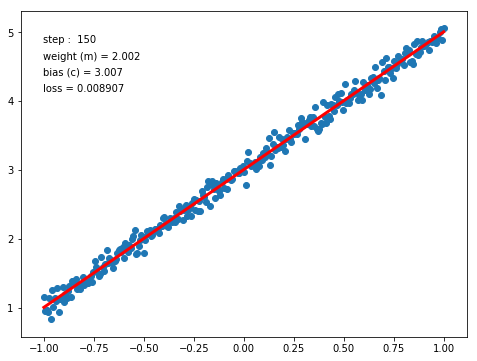

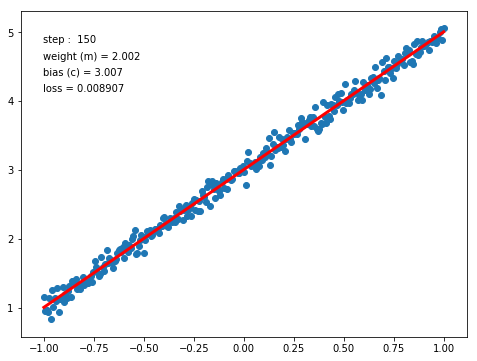

In [8]:
# make a figure and subplot
fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(1,1,1)

# specify the number of training steps
nTrain = 151

# start a tf session which will only be active until training ends
with tf.Session() as sess:
    # run the variable initializer
    sess.run(init)
    # define a file writer that will write the logs to a file in a given directory and merge
    writer = tf.summary.FileWriter("logs/", sess.graph)
    merged = tf.summary.merge_all()

    # train the network by running the train step nTrain times
    for i in range(nTrain):
        sess.run(train, feed_dict={x:xDat, y:yDat})
        summaryResult = sess.run(merged, feed_dict={x:xDat, y:yDat})
        writer.add_summary(summaryResult, i)

        # plot the current predicted line (with weights and biases) every 5 steps
        if (i%5 == 0):
            # get predicted values
            predictionVals = sess.run(prediction, feed_dict={x:xDat})
            lossVal = sess.run(loss, feed_dict={x:xDat, y:yDat})

            # plot data and predictions
            ax.clear()            
            ax.scatter(xDat, yDat)
            ax.plot(xDat, predictionVals, ls='-', color='r', lw=3)
            weightVar = sess.run( tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "layer_1/Weights:0")[0][0][0] )
            biasVar = sess.run( tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "layer_1/biases:0")[0][0][0] )
            plt.text(0.05, 0.9, "step :  {}".format(i), transform=ax.transAxes)
            plt.text(0.05, 0.85, "weight (m) = {0:.{1}}".format(weightVar, 4),transform=ax.transAxes)
            plt.text(0.05, 0.8, "bias (c) = {0:.{1}}".format(biasVar, 4),transform=ax.transAxes)
            plt.text(0.05, 0.75, "loss = {0:.{1}}".format(lossVal, 4),transform=ax.transAxes)
            display.clear_output(wait=True)
            plt.pause(0.05)
            display.display(fig)

Durint training, the weight and bias variables should approach the true values for m and c, respectively, as specified earlier.  A log file is create in the directory specified by the summary FileWriter (.logs/ in our case).  This log file is read by TensorBoard to produce a TensorFlow Graph and plots for the loss, weight and bias.  From within the working directory, the following command can be executed using the terminal:
```
~/current_working_dir$ tensorboard --logdir="logs"
```
This will produces a link that can be opened in a browser to show the TensorBoard interface.  We show an example of what the graph for this network looks like:
![](./graph.png)